In [178]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal

In [274]:
model = 'esm4'
pathout = '../../data/'+model+'/processed/'
adds = ['hfds','fgco2','intpp','spco2']
ds = xr.Dataset()
for add in adds:
    if add == 'spco2':
        pathoutnow=pathout+'global_means/'
    else:
        pathoutnow=pathout+'global_integrals/'
    da = xr.open_dataarray(pathoutnow+model+'_'+add+'.nc')
    
    # Average monthly data
    if (model=='cm4') & ((add=='fgco2') | (add=='intpp') | (add=='spco2')):
        times = xr.open_dataarray(pathout+'global_integrals/'+model+'_hfds.nc')['time']
        da = da.coarsen({'time':12}).mean().assign_coords({'time':times})
    ds[add] = da
# Cut drift years in cm4
if model=='cm4':
    ds = ds.isel({'time':slice(200,len(ds['time']))})

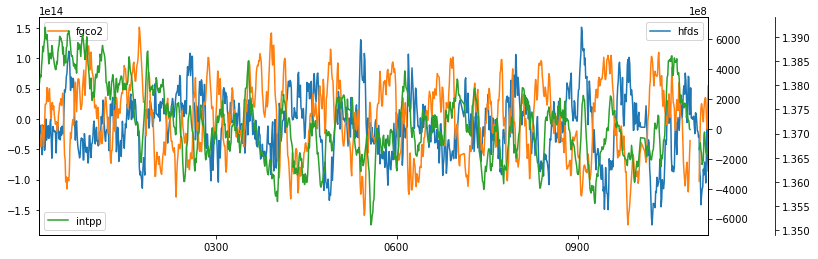

In [275]:
dsnow = ds.rolling(time=10,center=True).mean()

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.plot(dsnow['time'],dsnow['hfds'],color='tab:blue',label='hfds')
ax2 = ax1.twinx()
ax2.plot(dsnow['time'],dsnow['fgco2'],color='tab:orange',label='fgco2')
ax3 = ax1.twinx()
ax3.plot(dsnow['time'],dsnow['intpp'],color='tab:green',label='intpp')
offsetax = 1+1/10
ax3.spines.right.set_position(("axes",offsetax))

ax1.autoscale(enable=True,axis='x',tight=True)
ax2.autoscale(enable=True,axis='x',tight=True)
ax3.autoscale(enable=True,axis='x',tight=True)

ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
ax3.legend(loc='lower left')

In [276]:
rolling = False
x = ds['hfds']
y = ds['fgco2']
if rolling:
    x = x.rolling(time=20,center=True).mean()
    y = y.rolling(time=20,center=True).mean()    
mask = ~np.isnan(x) & ~np.isnan(y)
result = stats.linregress(x=x[mask],y=y[mask])
ynew = result.slope*x + result.intercept
ds['fgco2_hfds'] = ynew.copy()

In [277]:
result

LinregressResult(slope=-1.94600448621858e-11, intercept=371.1364749709703, rvalue=-0.6008976089310812, pvalue=2.0210154909048996e-109, stderr=7.794343615581292e-13, intercept_stderr=134.6304099070374)

Text(-660727415596646.4, 18827.2544921875, 'R^2 = 0.36107793641909064')

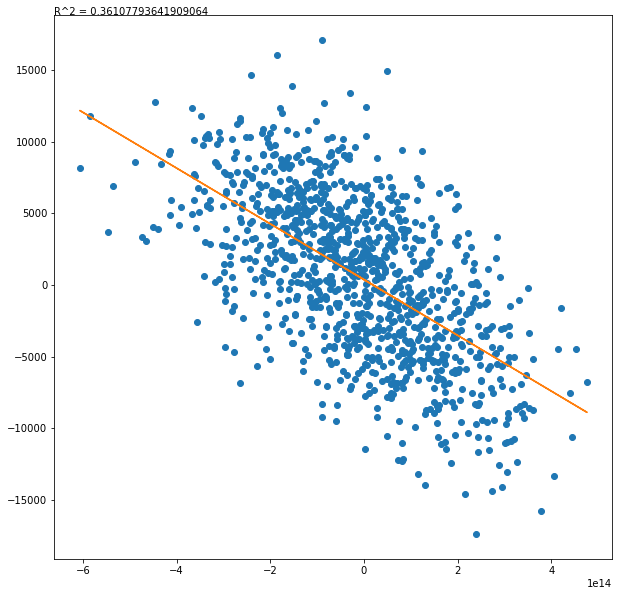

In [278]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(x,y)
ax.plot(x,ynew,color='tab:orange')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(xlims[0],ylims[1],'R^2 = '+str(result.rvalue**2))

<BarContainer object of 30 artists>

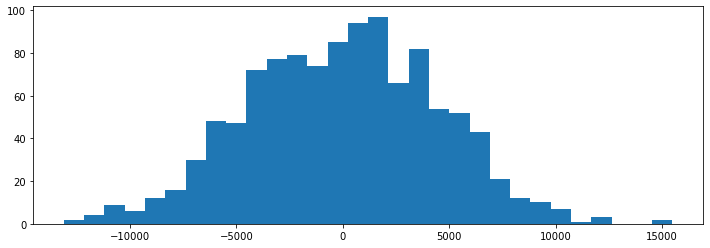

In [279]:
residuals = ds['fgco2'] - ds['fgco2_hfds']
mask = ~np.isnan(residuals)
d,bin_edges = np.histogram(residuals[mask],bins=30)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
fig,ax = plt.subplots(figsize = (12,4))
ax.bar(bin_centers,d,width = np.diff(bin_edges))

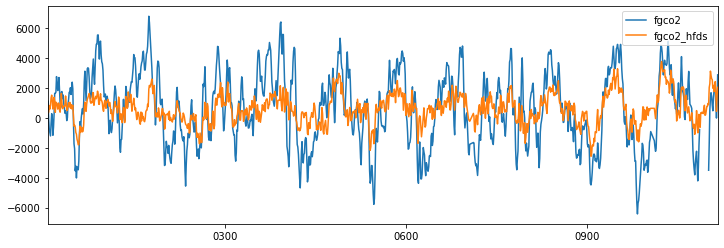

In [280]:
dsnow = ds.rolling(time=10,center=True).mean()

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.plot(dsnow['time'],dsnow['fgco2'],color='tab:blue',label='fgco2')
ax1.plot(dsnow['time'],dsnow['fgco2_hfds'],color='tab:orange',label='fgco2_hfds')

ax1.autoscale(enable=True,axis='x',tight=True)

ax1.legend(loc='upper right')

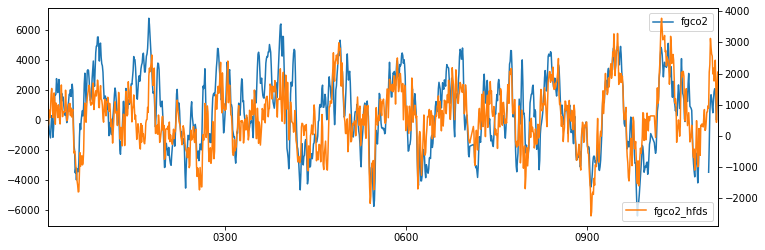

In [238]:
dsnow = ds.rolling(time=10,center=True).mean()

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.plot(dsnow['time'],dsnow['fgco2'],color='tab:blue',label='fgco2')

ax2 = ax1.twinx()
ax2.plot(dsnow['time'],dsnow['fgco2_hfds'],color='tab:orange',label='fgco2_hfds')

ax1.autoscale(enable=True,axis='x',tight=True)
ax2.autoscale(enable=True,axis='x',tight=True)

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

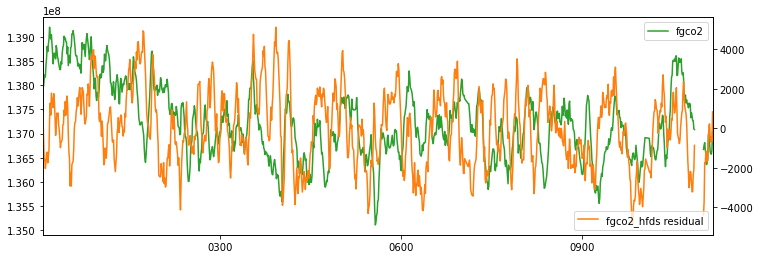

In [239]:
dsnow = ds.rolling(time=10,center=True).mean()

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.plot(dsnow['time'],dsnow['intpp'],color='tab:green',label='fgco2')

ax2 = ax1.twinx()
ax2.plot(dsnow['time'],dsnow['fgco2'] - dsnow['fgco2_hfds'],color='tab:orange',label='fgco2_hfds residual')

ax1.autoscale(enable=True,axis='x',tight=True)
ax2.autoscale(enable=True,axis='x',tight=True)

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

Text(147492621.6, -162.82588061451804, 'R^2 = 0.012327912054325365')

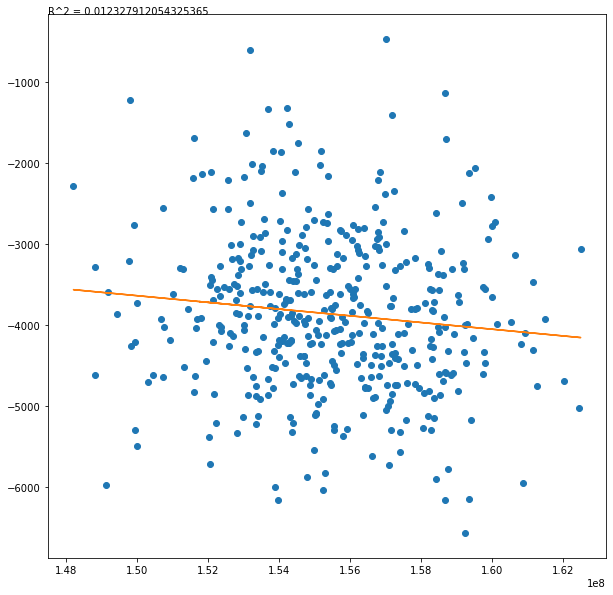

In [219]:
### Lagged regression to get impulse response
x = ds['intpp'].shift(shifts={'time':0},fill_value=np.nan)
y = ds['fgco2_hfds']
mask = ~np.isnan(x) & ~np.isnan(y)
result = stats.linregress(x=x[mask],y=y[mask])
ynew = result.slope*x + result.intercept

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(x,y)
ax.plot(x,ynew,color='tab:orange')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(xlims[0],ylims[1],'R^2 = '+str(result.rvalue**2))

In [69]:
ynew

<xarray.DataArray 'intpp' (time: 1110)>
array([      nan, 598.13574, 543.01465, ..., 665.0781 , 769.7959 ,
       643.19336], dtype=float32)
Coordinates:
  * time     (time) object 0001-07-02 12:00:00 ... 1120-07-02 12:00:00